<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simplest-effects-of-CP-on-percent-correct" data-toc-modified-id="Simplest-effects-of-CP-on-percent-correct-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simplest effects of CP on percent correct</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li><li><span><a href="#Viewing-duration" data-toc-modified-id="Viewing-duration-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Viewing duration</a></span></li><li><span><a href="#VD-x-signedCoh" data-toc-modified-id="VD-x-signedCoh-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>VD x signedCoh</a></span></li></ul></li><li><span><a href="#Two-predictors" data-toc-modified-id="Two-predictors-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Two predictors</a></span></li></ul></li><li><span><a href="#With-quickpsy-package" data-toc-modified-id="With-quickpsy-package-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>With <code>quickpsy</code> package</a></span></li><li><span><a href="#With-glm-function" data-toc-modified-id="With-glm-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>With <code>glm</code> function</a></span></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 11` dataset.

In [4]:
library(data.table)
library(ggplot2)        

In [5]:
# library(tidyverse) # masks data.table, so not good for now

In [6]:
# library(psych)
my_logistic <- function(x_vals, linear_func) {
    return(exp(linear_func(x_vals))/(1+exp(linear_func(x_vals))))
}

In [7]:
linear_func <- function(coefs) {
    f <- function(x) {
        return(coefs[1]+coefs[2]*x)
    }
    return(f)
}

In [8]:
fit_logistic_single_pred <- function(datatable, response, response_value, predictor) {
    logistic_fit <- substitute(glm(response ~ predictor, family=binomial(), data=datatable))
    print(summary(eval(logistic_fit)))
    betas <- coef(eval(logistic_fit))
#     print(betas)
    x <- substitute(
        unique(datatable[order(predictor),.(predictor),by=.(predictor)][,predictor])
        )
    fit_prop <- my_logistic(eval(x), linear_func(betas))
    fitted_curve <- data.table(x=eval(x), y=fit_prop)
    
    # control output figure size
    options(repr.plot.width=8, repr.plot.height=4)
    g <- substitute(
        ggplot(datatable[,.(prop=sum(response==response_value)/.N),by=predictor], aes(x=predictor, y=prop)) + 
        geom_point() +
        geom_line(aes(x=x, y=y),data=fitted_curve,inherit.aes=FALSE) +
        ylim(0,1)
        )
    return(eval(g))
}

## Dataset handling

Let's load and inspect the dataset.

In [9]:
# load dataset
data <- fread('../../data/Pilot11/psychophysical_data.csv')
data[,presenceCP:=as.factor(presenceCP)]
data[,choice:=as.factor(choice)]

In [10]:
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [11]:
str(data)

Classes ‘data.table’ and 'data.frame':	476 obs. of  10 variables:
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 1 1 1 1 1 1 2 2 2 2 ...
 $ correct        : logi  TRUE TRUE TRUE FALSE TRUE FALSE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 2 1 2 2 2 1 1 1 1 ...
 $ viewingDuration: num  0.5 0.4 0.2 0.5 0.4 0.5 0.4 0.5 0.1 0.3 ...
 $ signedCoherence: int  -60 NA -60 NA NA NA 12 12 -12 0 ...
 $ coherence      : int  60 24 60 12 12 12 12 12 12 0 ...
 $ choice_time    : num  0.921 0.86 1.125 0.875 0.979 ...
 $ exactVD        : num  0.525 0.424 0.203 0.525 0.407 ...
 $ signedCohLast  : int  -60 -24 -60 12 -12 12 12 12 -12 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [12]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,signedCohLast
1,left,TRUE,no,0.5,-60,60,0.9206421,0.5248945,-60
2,left,TRUE,yes,0.4,NA,24,0.8598706,0.4237288,-24
3,left,TRUE,no,0.2,-60,60,1.1245399,0.2033898,-60
4,left,FALSE,yes,0.5,NA,12,0.8751249,0.5254237,12
5,left,TRUE,yes,0.4,NA,12,0.9794417,0.4067797,-12
6,left,FALSE,yes,0.5,NA,12,1.1367451,0.5073636,12


## Simplest effects of CP on percent correct

**Question:** Does the physical presence of a CP affect state inference?  
**Hypotheses:** At fixed viewing duration the (physical) presence of a CP will decrease accuracy.  
**Method:** Hypothesis testing, i.e. is the difference in percent correct between the `CP` and `nonCP` conditions significantly different from 0?

Let's build a contingency table and perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#Example).

In [25]:
contingency <- as.matrix(data[coherence==36, .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)

In [28]:
t(contingency)

,no,yes
Corrrect,33,12
Incorrect,21,4


In [29]:
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help


	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.383
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1094844 2.0546144
sample estimates:
odds ratio 
  0.528421 


We conclude that the test is not significant, i.e., we do **not** reject the null hypothesis that percent correct is the same with and without change points.

In [39]:
# we could run the same test for a higher coherence value (uncomment the following)
# contingency2 <- as.matrix(data[coherence==48, .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
# fisher.test(t(contingency2)) 

In [34]:
# fisher.test(t(contingency), alternative="less")

In [35]:
# fisher.test(t(contingency), alternative="greater")

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start super simple with the equation:
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.
The current data (Pilot 11) has 11 stimulus levels, which correspond to the 11 signed coherence values: 

In [36]:
unique(data[order(signedCohLast),.(signedCohLast)][,signedCohLast])

[1] -60 -48 -36 -24 -12   0  12  24  36  48  60


Call:
glm(formula = choice ~ signedCohLast, family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9927  -0.8902   0.5435   0.9513   1.6392  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.558294   0.105590   5.287 1.24e-07 ***
signedCohLast 0.026656   0.003156   8.445  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.16  on 475  degrees of freedom
Residual deviance: 548.44  on 474  degrees of freedom
AIC: 552.44

Number of Fisher Scoring iterations: 3



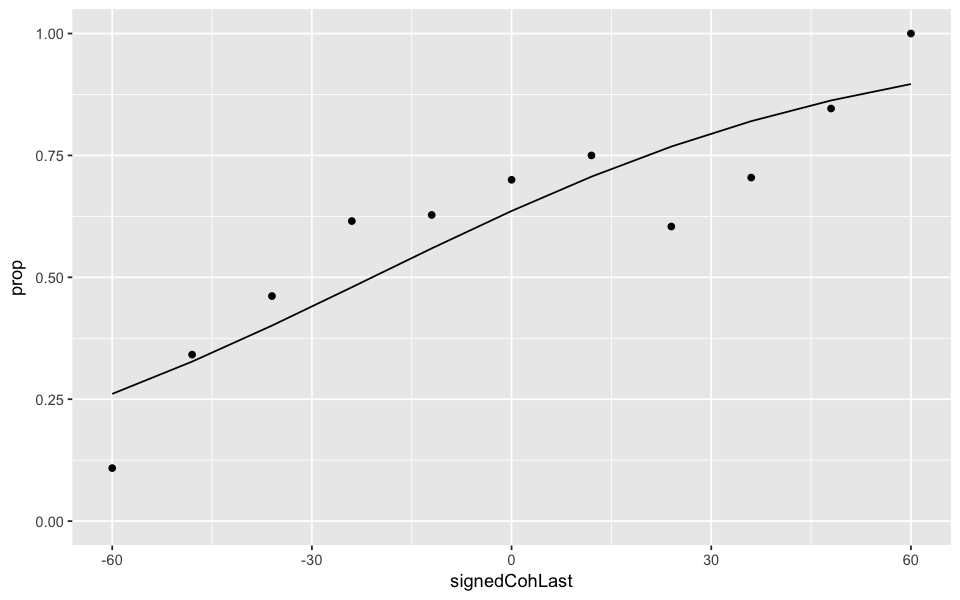

In [8]:
fit_logistic_single_pred(data, choice, "right", signedCohLast)

The z-value for the intercept term $\beta_0$ is usually not useful. However, for the $\beta_1$ term, it allows us to test the null hypothesis that $\beta_1=0$. Since the p-value is extremely small ($<10^{-16}$), the test is significant and we reject the null hypothesis. In other words, **there is an effect of signed coherence on the likelihood for the subject to choose "right".**

Plotting the fitted curve together with the raw data yields:

#### Viewing duration

**With prob(choose right)**

Now, what does the same fitting procedure look like if we change the predictor to be viewing duration (note that now, $i$ denotes the various exact viewing durations)?
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{vd}_i$$



Call:
glm(formula = choice ~ viewingDuration, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5283  -1.3050   0.8632   0.9886   1.1235  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.9620     0.2263   4.251 2.13e-05 ***
viewingDuration  -1.6677     0.6769  -2.464   0.0137 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.16  on 475  degrees of freedom
Residual deviance: 629.02  on 474  degrees of freedom
AIC: 633.02

Number of Fisher Scoring iterations: 4



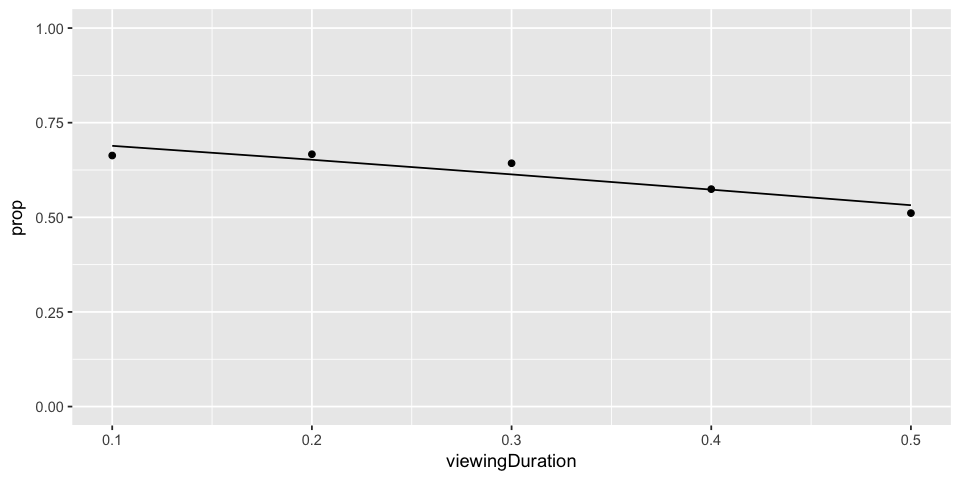

In [24]:
fit_logistic_single_pred(data, choice, "right", viewingDuration)

**With percent correct**

It could make more sense to look at percentage correct. Note how, now, the intercept coefficient will be interpretable:


Call:
glm(formula = correct ~ viewingDuration, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6926  -1.2784   0.8161   0.8991   1.0797  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)   
(Intercept)     0.002925   0.221703   0.013  0.98947   
viewingDuration 2.313655   0.706495   3.275  0.00106 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 609.14  on 475  degrees of freedom
Residual deviance: 598.15  on 474  degrees of freedom
AIC: 602.15

Number of Fisher Scoring iterations: 4



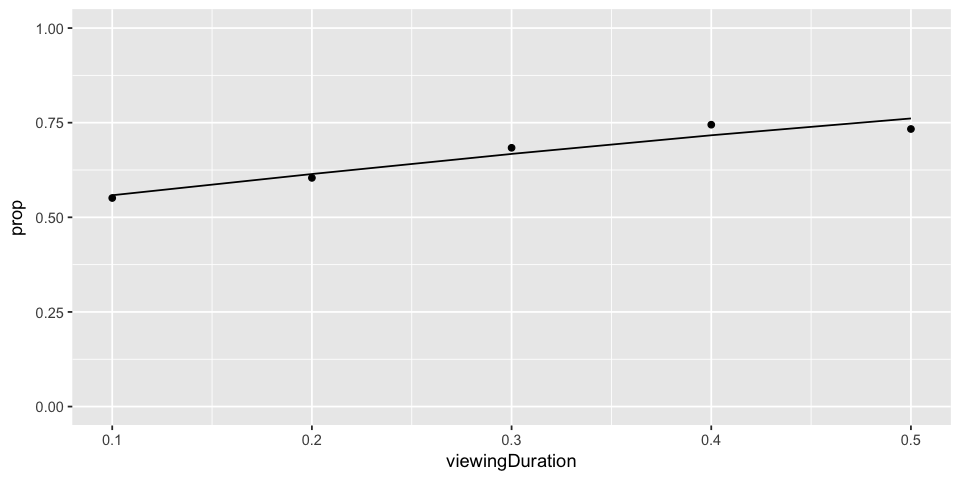

In [26]:
fit_logistic_single_pred(data, correct, TRUE, viewingDuration)

Fitting a line to the plot above looks quite indistinguishable.

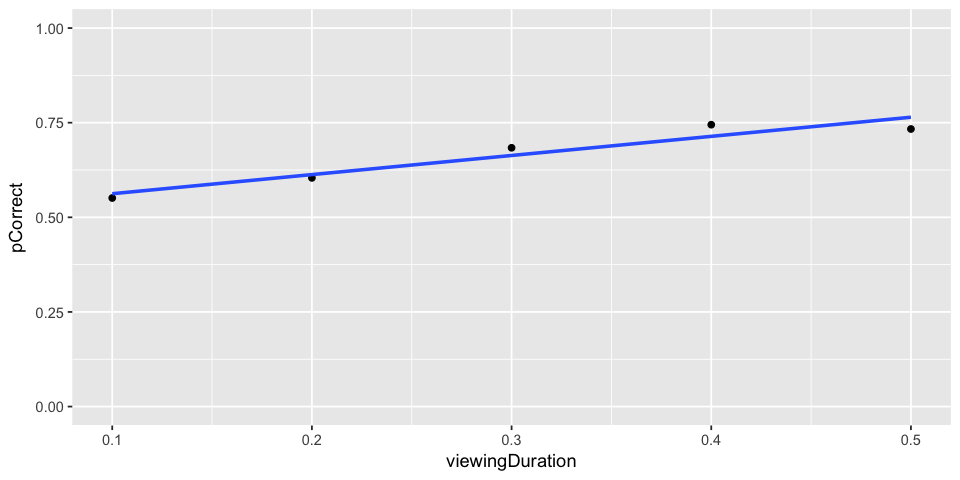

In [23]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data[, .(pCorrect=sum(correct)/.N), by=viewingDuration], aes(x=viewingDuration, y=pCorrect)) +
    geom_point() +
    geom_smooth(se = FALSE, method = lm, show.legend=TRUE) +
    ylim(0,1)

**percent correct with log(VD)**

Let's first redo the last fit with the log of the viewing duration.

In [27]:
# logistic_fit_3_log <- glm(correct ~ log(viewingDuration), family=binomial(), data=data)
# summary(logistic_fit_3_log)
# betas_3_log <- coef(logistic_fit_3_log)
# print(betas_3_log)
# x_3_log <- log(x_3)
# fit_3_prop_log <- my_logistic(x_3_log, linear_func(betas_3_log))
# fitted_curve_3_log <- data.table(x=x_3_log, y=fit_3_prop_log)

In [28]:
# # control output figure size
# options(repr.plot.width=8, repr.plot.height=5)
# ggplot(data[,.(pCorrect=sum(correct)/.N),by=viewingDuration], aes(x=log(viewingDuration), y=pCorrect)) + 
#     geom_point() +
#     geom_line(aes(x=x, y=y),data=fitted_curve_3_log,inherit.aes=FALSE) +
#     ylim(0,1)

This looks the same. Not sure how to interpret the intercept.

#### VD x signedCoh 

Here, $i$ is the level of signed coherence, and $x^\text{prod}$ is the product of VD and signed coherence.
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{prod}_i$$ 

In [29]:
data[,prod:=signedCohLast * viewingDuration]
str(data)

Classes ‘data.table’ and 'data.frame':	476 obs. of  11 variables:
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 1 1 1 1 1 1 2 2 2 2 ...
 $ correct        : logi  TRUE TRUE TRUE FALSE TRUE FALSE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 2 1 2 2 2 1 1 1 1 ...
 $ viewingDuration: num  0.5 0.4 0.2 0.5 0.4 0.5 0.4 0.5 0.1 0.3 ...
 $ signedCoherence: int  -60 NA -60 NA NA NA 12 12 -12 0 ...
 $ coherence      : int  60 24 60 12 12 12 12 12 12 0 ...
 $ choice_time    : num  0.921 0.86 1.125 0.875 0.979 ...
 $ exactVD        : num  0.525 0.424 0.203 0.525 0.407 ...
 $ signedCohLast  : int  -60 -24 -60 12 -12 12 12 12 -12 0 ...
 $ prod           : num  -30 -9.6 -12 6 -4.8 6 4.8 6 -1.2 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 



Call:
glm(formula = choice ~ prod, family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4154  -0.9315   0.5487   0.9556   1.7576  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54701    0.10665   5.129 2.91e-07 ***
prod         0.09643    0.01137   8.484  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.16  on 475  degrees of freedom
Residual deviance: 531.82  on 474  degrees of freedom
AIC: 535.82

Number of Fisher Scoring iterations: 4



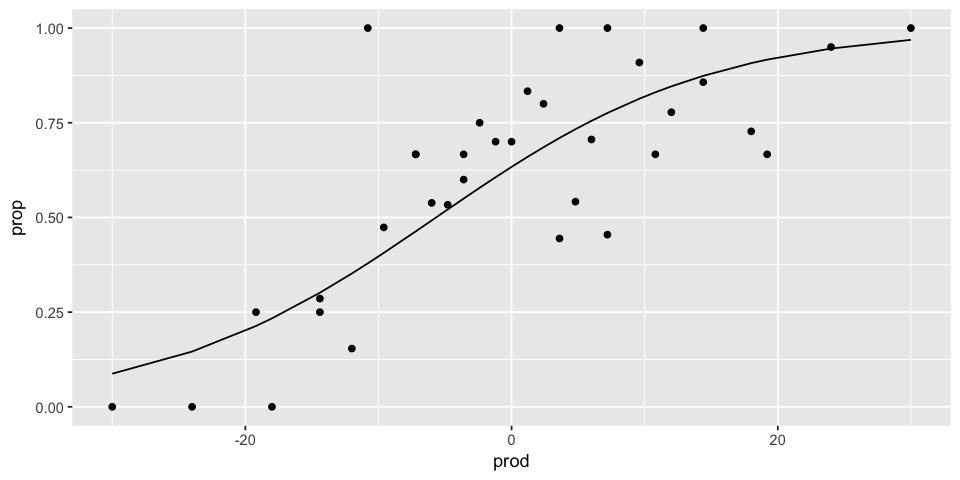

In [30]:
fit_logistic_single_pred(data, choice, "right", prod)

Fit definitely seems poorer than [here](#cohpred).

### Two predictors

## With `quickpsy` package

In [ ]:
# for an explanation of masked objects, see here:
# https://stackoverflow.com/a/39137111
library(quickpsy)

In [ ]:
# let's set presenceCP as factor variable in a temporary data.table before upcoming grouping
tmp <- data[,`:=`(presenceCP=as.factor(presenceCP))]

# build data.table used by the quickpsy package
psychometric <- tmp[, 
                    .(numCorrect=sum(correct), N=.N), 
                    by=.(coherence, viewingDuration, presenceCP)]
psychometric[coherence==0, numCorrect:=as.integer(N/2)]
str(psychometric)

$$\psi(x)=\gamma + (1-\gamma-\lambda) * F(x)$$
where $\gamma$ is the guess rate, $\lambda$ is the lapse rate and $F$ is a sigmoidal-shape function with asymptotes at 0 and 1.

In [ ]:
fitWithLapses <- quickpsy(psychometric, 
                          coherence, 
                          numCorrect, N,
                          grouping = c(viewingDuration, presenceCP), lapses  = T, bootstrap = 'none') 

ggplot() +
  facet_grid(viewingDuration~presenceCP) +
  geom_point(data = fitWithLapses$averages, 
             aes(x = coherence, y = prob)) +
  geom_line(data = fitWithLapses$curves, 
            aes(x = x, y = y)) +
  ylim(0, 1.25) # we include ggplot ylim to be able to visualize what is going on

In [ ]:
# perform the fits
# ref here:
# http://dlinares.org/lapsesquickpsy.html
fit <- quickpsy(psychometric, coherence, numCorrect, N, grouping = .(viewingDuration, presenceCP),
               log=FALSE, fun=logistic_fun, lapses=TRUE, bootstrap="nonparametric")

In [ ]:
str(fit)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
plot(fit) + xlim(c(0,60))

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=3)
plotpar(fit) #+ ylim(c(0,.25))

In [ ]:
plotthresholds(fit) + ylim(c(-60,60))


## With `glm` function

In [ ]:
# psychometric[,numChooseLeft := N - numChooseRight]
# str(psychometric)

In [ ]:
# # let's first follow this example:
# # http://www.dlinares.org/psychopract.html#fitting-using-generalized-linear-models
# model <- glm( cbind(numChooseRight, numChooseLeft) ~ signedCoherence, 
#              data= psychometric, 
#              family = binomial(probit))

# xseq <- seq(-60, 60, 1)
# yseq <- predict(model, data.frame(signedCoherence = xseq), type = 'response')
# curve <- data.frame(xseq, yseq)

# p <- ggplot() +
#   geom_point(data = psychometric[,.(signedCoherence, chooseRight=numChooseRight / N)], 
#              aes(x = signedCoherence, y = chooseRight)) +
#   geom_line(data = curve,aes(x = xseq, y = yseq))
# p

The problem here is that I have a single regressor, namely, `signedCoherence`. This is not what I want.

In [ ]:
# Try instead this example
#https://www.statmethods.net/advstats/glm.html
# with good interpretation here:
# https://stats.idre.ucla.edu/r/dae/logit-regression/

In [ ]:
fit2 <- glm(choice ~ signedCohLast * exactVD + presenceCP, data = data, family=binomial())

In [ ]:
summary(fit2)

In [ ]:
anova(fit2)

In [ ]:
confint(fit2) # 95% CI for the coefficients, using profiled log-likelihood
confint.default(fit2)  # CIs using standard errors

In [ ]:
# odds ratios and 95% CI
exp(cbind(OddsRatio = coef(fit2), confint(fit2)))

In [ ]:
library("aod")
wald.test(b = coef(fit2), Sigma = vcov(fit2), Terms = 4)

In [ ]:
# better to use this
# https://stats.idre.ucla.edu/r/dae/logit-regression/
predict(fit2, type="response") # predicted values
residuals(fit2, type="deviance") # residuals

In [ ]:
cdplot(choice~signedCoherence, data=tmp_glm) 

In [ ]:
cdplot(choice~viewingDuration, data=tmp_glm) 

In [ ]:
# now try this
#https://datascienceplus.com/perform-logistic-regression-in-r/

# Psychophysics tutorial